#   `lesson02`:  Image Processing I

Most of the Python processing you have done before now has probably consisted of plain-text and numerical data.  Visual and signal data are often accessed as images.  If you want to build a computer process around images, then you need a standardized way of storing and cleaning data, identifying features, and applying transformations.

**Objectives:**
-   Distinguish image formats and data structures, including color and greyscale representations.
-   Manipulate image
-   **Process images through a standardized pipeline for image analysis.**
-   Identify image features such as bones and tumors.


This lesson is divided into two parts:

1.  **(Class)**  We will cover the structure and format of image data and common features and statistics.
2.  **(Team)**  You will fill out a basic image processing workflow using MRI brain scan data.

In [ ]:
# necessary for Azure due to NumPy 1.16 deprecations.
!pip install --upgrade scikit-image==0.14.2 numpy==1.15.4

In [1]:
#   Some library boilerplate.
import numpy as np
import matplotlib.pyplot as plt
from skimage import data,io,filters,exposure
import skimage

##  Image Data

A picture, in the real world, is a two-dimensional representation of something.  That _something_ can be three-dimensional or itself flat.

<img src="https://whitehotmagazine.com//UserFiles/image/2012/Buckminster%20Fuller/Fuller_LaminarGeodesic.jpg" width="75%;" alt="Buckminster Fuller's _Laminar Geodesic Dome_"/>

Since computer screens are flat, we frequently interact with data as pictures rather than something more volumentric.

<img src="https://i.kinja-img.com/gawker-media/image/upload/s--K2mqoGa6--/c_scale,f_auto,fl_progressive,q_80,w_800/aflxtfyesukzvfd5abnl.png" width="75%;" alt="Princess Leia as a space-occupying hologram."/>

A computer screen is a grid of square pixels.  Each pixel is capable of displaying itself in one of about 16 million colors.

One can imagine storing a picture on a computer in a number of ways:  the actual location and value of each pixel (bitmaps); the path taken by a pen to redraw the image (vector graphics); or a decompression algorithm from numbers to a graphic (JPEG/PNG).  Image-processing libraries take care of that transformation for us and present an image as a collection of values in a grid corresponding to the pixels.

To start off, let's load a simple black-and-white image.  We will use the [_scikit-image_](https://scikit-image.org/) package to handle the file.

<img src="./img/buckminster-fuller-geodesic-tensegrity-sphere_bw.png">

In [2]:
image_bw_path = './img/buckminster-fuller-geodesic-tensegrity-sphere_bw.png'
image_bw = io.imread( image_bw_path )

Examine the output of this image.  Look at its data type, its size and shape, and the values in it.  (How can you use NumPy to find these out?)

In [3]:
image_bw

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

What do you see?  What is the range of values?

Black-and-white images are straightforward in that only two values need to be stored, typically `0` and `1` or `0` and `255`.  (More on why `255` below.)

Let's look at a grayscale image now, something with more variation.

<img src="./img/buckminster-fuller-geodesic-tensegrity-sphere_gray.png">

It looks very similar, but in fact has gray elements instead of just black ones.

In [4]:
image_gray_path = './img/buckminster-fuller-geodesic-tensegrity-sphere_gray.png'
# load the image as image_gray

In [6]:
image_gray = io.imread(image_gray_path)

Once again, what is the range of values, the shape, etc.?

Before we move in, it's worth considering the tools that we need to successfully analyze an image.  Thus far, you can either show an image as an array:

In [21]:
image_gray.shape

(128, 128, 4)

or you can display it as an image again:

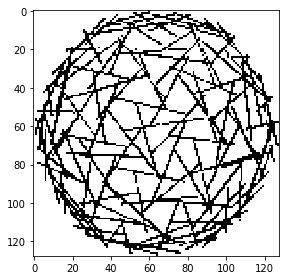

In [8]:
io.imshow( image_bw )

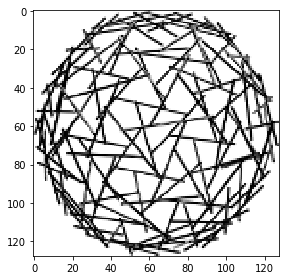

In [9]:
io.imshow( image_gray )

### Image Statistics

If the human eye fails to pick out features, however, you risk missing key elements of the image.  To offset this risk, we can use image statistics to obtain a more fully-faceted idea of what the picture contains.

The first of these is the _histogram_.  Histograms, as you'll recall, count up the number of times something occurs.  For instance, for a class, the grade distribution of As, Bs, etc., is a histogram.  For an image, a histogram can describe the color distribution of pixels.

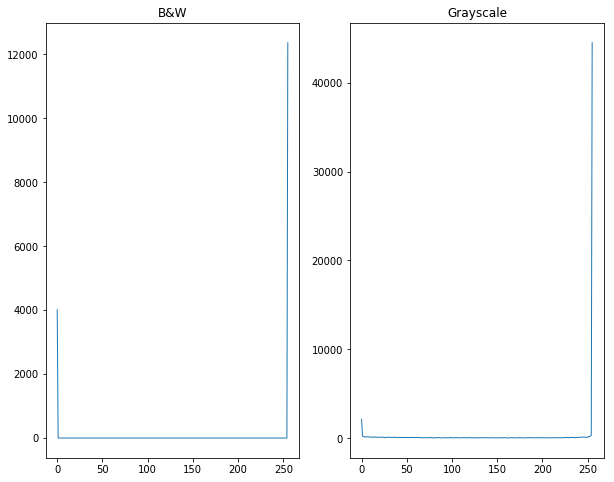

In [17]:
# Get the histogram of the black-and-white image.
hist_bw,hist_centers_bw = exposure.histogram( image_bw )

# Get the histogram of the grayscale image.
hist_gray,hist_centers_gray = exposure.histogram( image_gray )

fig,ax = plt.subplots( ncols=2,figsize=( 10,8 ) )

ax[ 0 ].plot( hist_centers_bw,hist_bw,lw=1 )
ax[ 0 ].set_title( 'B&W' )
ax[ 1 ].plot( hist_centers_gray,hist_gray,lw=1 )
ax[ 1 ].set_title( 'Grayscale' )
plt.show()

It's subtle, but you can see that the image on the left has sharp peaks at black (`0`) and white (`255`), while the image on the right has soften peaks and some fuzziness along the line, indicating the presence of a few gray pixels at intermediate values.

Other images would, of course, have different histograms:

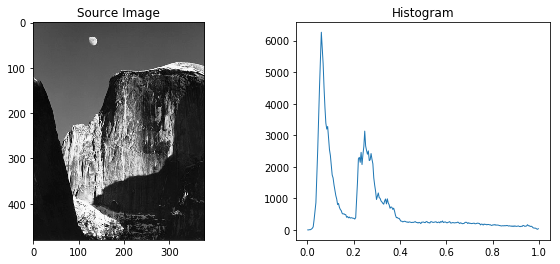

In [34]:
image_hist_path = './img/ansel-adams-moon-and-half-dome.jpg'
image_hist = io.imread( image_hist_path,as_gray=True )

hist_,hist_centers_ = exposure.histogram( image_hist )

fig,ax = plt.subplots( ncols=2,figsize=( 10,4 ) )

ax[ 0 ].imshow( image_hist,cmap='Greys_r' )
ax[ 0 ].set_title( 'Source Image' )
ax[ 1 ].plot( hist_centers_,hist_,lw=1 )
ax[ 1 ].set_title( 'Histogram' )

plt.show()

### Color Images

If black-and-white and grayscale images are stored as values from `0` to `255`, how do computers deal with color?

Computer screens use _additive color_, or color based on mixing red, green, and blue to produce other colors.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/AdditiveColor.svg/145px-AdditiveColor.svg.png)

Each screen pixel is addressed by location and set with a particular value.  This value has [32 bits](https://en.wikipedia.org/wiki/Color_depth#True_color_(24-bit)):  one byte each to describe the amount of red, green, and blue light, and the _alpha_ channel, or transparency of the pixel.  (For a gray pixel, the color values are all set equal and the alpha is set to `255`.)

![](./img/pixel_color.png)

Every color that can be shown on a typical computer display is represented:

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/16777216colors.png" width="75%;" alt="A square showing 16 million colors."/>

(Of course, the intensity can vary from black to white as well.)

Since there are three colors (ignoring alpha), what shape would you expect a loaded image to have as an array?  Let's check your intuition.

![](./img/mandelbrot-set.png)

In [18]:
image_color_path = './img/mandelbrot-set.png'
# load the image as image_color

In [19]:
image_color = io.imread(image_color_path)

The image, formerly just a grid, now has a third dimension, which we can think of as three layers.  The top layer corresponds to the redness of the image, the middle to the greenness, the bottom to the blueness.

![](./img/image_layers.png)

We now have more information about the image than we had before.  For instance, some feature we are interested in may only show up in one color channel, or in all three.

Imagine, for instance, a satellite image.  If you are tracking snowfall or cloud cover, you know that those features are "white" and close to equal intensity in all color channels.  Something that is intense in red and green but not blue would appear yellow and may be a desert.

![](./img/satellite-caucasus.jpg)

By applying rules such as blue only for water and green only for vegetation, you can automate surveys and satellite analysis.

Back to our Mandelbrot set image.

![](./img/mandelbrot-set.png)

If we plot each color layer and its histogram separately, we can see how the features of the overall image interrelate.

We do this for red together.  You should also do this for green and blue.

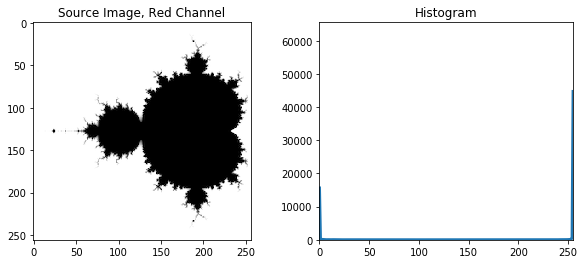

In [47]:
image_r = image_color[ :,:,0].copy()
hist_r,hist_centers_r = exposure.histogram( image_r )

fig,ax = plt.subplots( ncols=2,figsize=( 10,4 ) )

ax[ 0 ].imshow( image_r,cmap='binary_r' )
ax[ 0 ].set_title( 'Source Image, Red Channel' )
ax[ 1 ].plot( hist_centers_r,hist_r,lw=3 )
ax[ 1 ].set_title( 'Histogram' )
ax[ 1 ].set_ylim( ( 0,256**2 ) )
ax[ 1 ].set_xlim( ( 0,255 ) )

plt.show()

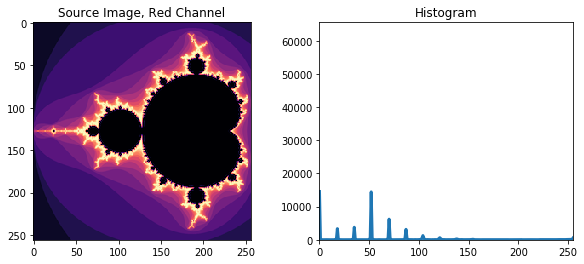

In [50]:
image_g = image_color[ :,:,1].copy()
hist_g,hist_centers_g = exposure.histogram( image_g )

fig,ax = plt.subplots( ncols=2,figsize=( 10,4 ) )

ax[ 0 ].imshow( image_g,cmap='magma' )
ax[ 0 ].set_title( 'Source Image, Red Channel' )
ax[ 1 ].plot( hist_centers_g,hist_g,lw=3 )
ax[ 1 ].set_title( 'Histogram' )
ax[ 1 ].set_ylim( ( 0,256**2 ) )
ax[ 1 ].set_xlim( ( 0,255 ) )

plt.show()

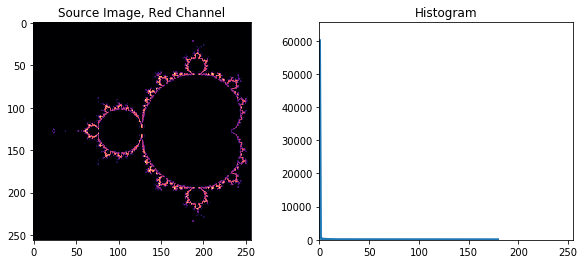

In [51]:
image_g = image_color[ :,:,2].copy()
hist_g,hist_centers_g = exposure.histogram( image_g )

fig,ax = plt.subplots( ncols=2,figsize=( 10,4 ) )

ax[ 0 ].imshow( image_g,cmap='magma' )
ax[ 0 ].set_title( 'Source Image, Red Channel' )
ax[ 1 ].plot( hist_centers_g,hist_g,lw=3 )
ax[ 1 ].set_title( 'Histogram' )
ax[ 1 ].set_ylim( ( 0,256**2 ) )
ax[ 1 ].set_xlim( ( 0,255 ) )

plt.show()

What interesting features do you observe from those histograms?

We'll revisit color images in `lesson05` when we examine satellite image data.  For now, we'll explore feature identification in grayscale images.

##  Image Features

Next, as a team, you will explore how automatic feature identification and manipulation works.

Magnetic resonance imaging (MRI) data are frequently stored as grayscale images where lightness corresponds to a response in the signal.

<img src="http://jnm.snmjournals.org/content/46/1_suppl/151S/F2.large.jpg" width="75%;" alt="A series of MRI pictures after brain surgery."/>

(For this portion, we are indebted to [Richard Barnes](http://rbarnes.org/)' outline on [Stack Overflow](https://stackoverflow.com/questions/49834264/mri-brain-tumor-image-processing-and-segmentation-skull-removing).)

Elements that are commonly present, such as bones, are frequently removed in order to clean up the picture.  With a little bit of finesse, this process can be automated, since the skull generally occurs in the same place in all of the pictures.  This is called "skull stripping," and we'll start by identifying and removing the skull from our set of images.

We will use a set of MRI images obtained from the [XNAT](https://central.xnat.org/) repository, the `IGT_GLIOMA` data set provided by Ferenc Jolesz.  Each of these images contains a brain scan for a [glioma](https://en.wikipedia.org/wiki/Glioma), a relatively common kind of brain tumor.

<img src="https://prod-images.static.radiopaedia.org/images/16514952/bff0d7dde0729713759de61d0d0a8f_big_gallery.jpeg" width="33%;" alt="Left frontal low-grade glioma."/>

![](./img/scan.gif)

Set up a display function for convenience in working with the image data.  Sometimes MRI data are stored in blue-green-red order instead of red-green-blue order, so we have a convenience function to deal with that.

In [52]:
#   Some library boilerplate.
import numpy as np
import matplotlib.pyplot as plt
from skimage import data,io,filters,exposure
import skimage

In [53]:
def ShowImage( title,img,ctype ):
    plt.figure( figsize=( 10, 10 ) )
    if ctype == 'bgr':  # switch to RGB
        b = img[ :,:,0 ].copy()
        g = img[ :,:,1 ].copy()
        r = img[ :,:,2 ].copy()
        rgb_img = np.stack( [ r,g,b ],axis=2 )
        plt.imshow( rgb_img )
    elif ctype == 'gray':
        plt.imshow( img,cmap='gray' )
    elif ctype == 'rgb':
        plt.imshow( img )
    else:
        raise Exception( "Unknown colour type" )
    plt.axis( 'off' )
    plt.title( title )
    plt.show()

First, we need to load an image to work with.

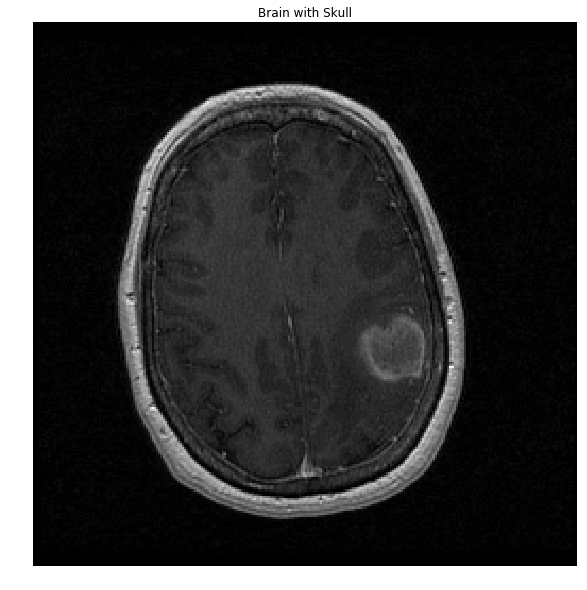

In [78]:
brain_path = './data/000079.png'
image_brain = skimage.io.imread( brain_path )
image_brain = image_brain >> 8
ShowImage( 'Brain with Skull',image_brain,'gray' )

We examine the histogram of the image data in grayscale.

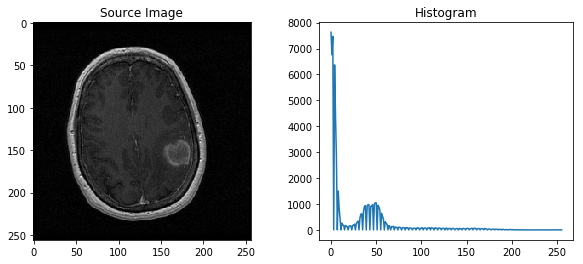

In [79]:
hist_brain,hist_centers_brain = exposure.histogram( image_brain )

fig,ax = plt.subplots( ncols=2,figsize=( 10,4 ) )

ax[ 0 ].imshow( image_brain,cmap='binary_r' )
ax[ 0 ].set_title( 'Source Image' )
ax[ 1 ].plot( hist_centers_brain,hist_brain )
ax[ 1 ].set_title( 'Histogram' )

plt.show()

In principle, this distribution tells us something about the kinds of methods that can be used to identify features.  For instance, notice that the skull and brain are very distinct in color from the background, verified by the histogram.  We can use this to select the skull and brain separately from the background.  One technique for accomplishing this is Li's method, which splits the histogram between peaks.

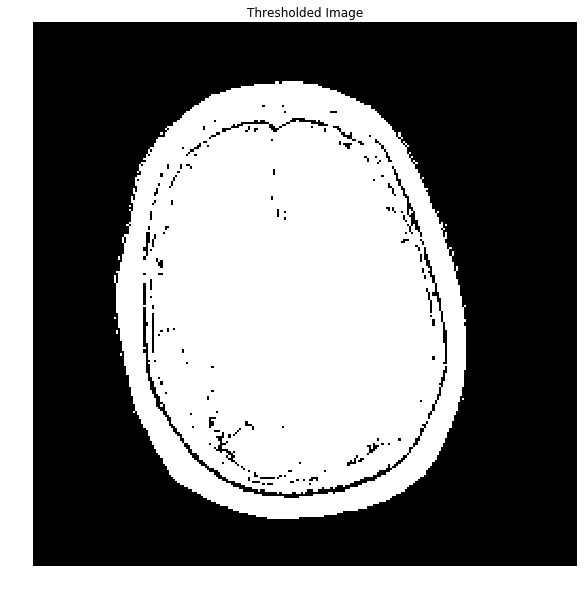

In [80]:
threshold = skimage.filters.threshold_li( image_brain )
thresh = image_brain > threshold
ShowImage( 'Thresholded Image',thresh,'gray' )

`thresh` represents the original image classified into light and dark portions according to the histogram.  We use `thresh` as a "mask" to distinguish parts of the image.  Overlaying the mask and the original image, we can see the area of detection.  You should analyze and understand each line in the subsequent code block.

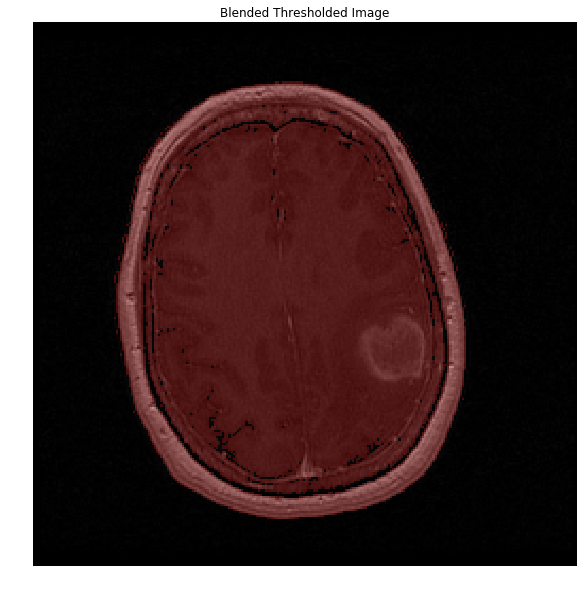

In [81]:
colormask = np.zeros( ( image_brain.shape[ 0 ],image_brain.shape[ 1 ],3),dtype=np.uint8 )
colormask[ thresh!=0 ] = np.array( ( 0,256,128 ) )
blended = ( np.dstack( ( image_brain, )*3 ) + colormask * 0.8 ) / ( 255 * 1.8 )
ShowImage( 'Blended Thresholded Image',blended,'bgr' )

The _scikit-image_ library, along with most image-processing libraries, is capable of identifying the separate components of a mask.

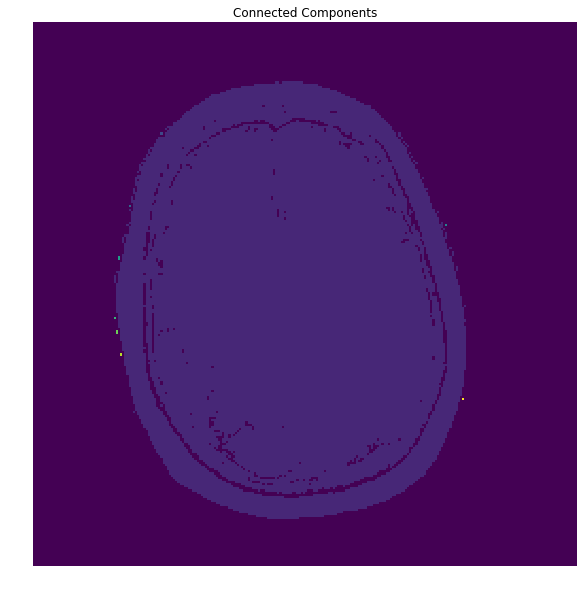

In [82]:
import skimage.morphology
markers = skimage.morphology.label( thresh )
ShowImage( 'Connected Components',markers,'rgb' )

We know there should be two components, not one huge one, so we have to find a way to separate the brain from the skull.  One way is to play with the threshold used in Li's method.  Another is to "erode" the image, or expand the holes in the mask until they meet and cut off one area from another.

Here, we attempt the latter.  We make a "disk" and apply it at the edges of the mask like a stamp.  This slightly expands the mask and makes the areas more distinct from each other.  We don't want to overdo it though.  (Try changing the disk size to see what we mean.)

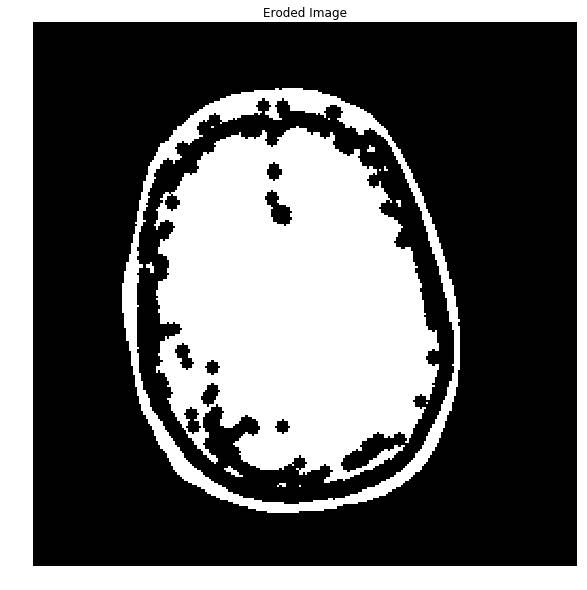

In [85]:
selem = skimage.morphology.disk(3)
eroded = skimage.morphology.erosion( thresh,selem )
ShowImage( 'Eroded Image',eroded,'gray' )

In this case, we can visually see two connected components, corresponding to the skull and the brain, and the computer agrees with this.  The larger of these is the brain, so we can find the larger component, select only it from the mask, and thus strip the skull from the image.

Now we can re-segment the image.

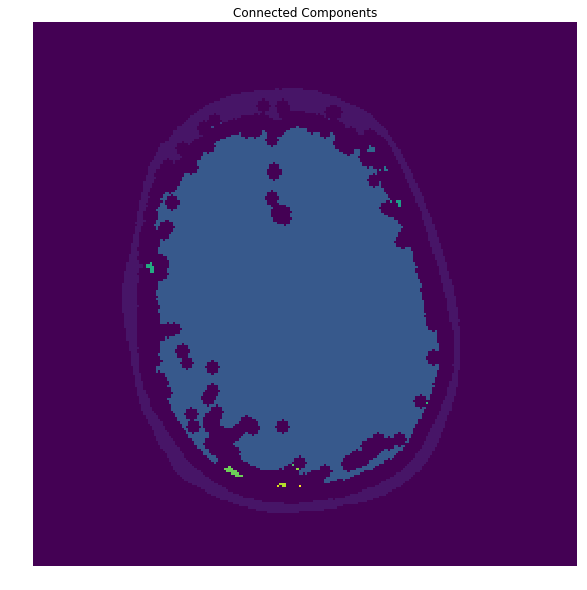

In [86]:
markers = skimage.morphology.label( eroded,connectivity=1 )
ShowImage( 'Connected Components',markers,'rgb' )

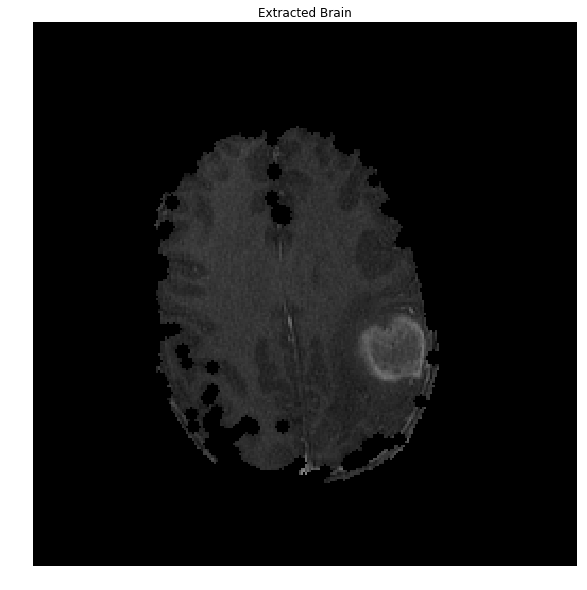

In [87]:
# Get the area taken by each component.  (Ignore label 0 since this is the background.)
marker_area = [ np.sum( markers==m ) for m in range( np.max( markers ) ) if m!=0 ] 

# Get label of largest component by area
largest_component = np.argmax( marker_area ) + 1  # add 1 since we dropped zero above                        

# Get pixels which correspond to the brain.
brain_mask = ( markers==largest_component )

# Make a copy of the original image and select only those pixels corresponding to the brain.
image_brain_out = np.dstack( ( image_brain, )*3 )
image_brain_out[ brain_mask==False ] = ( 0,0,0 )
ShowImage( 'Extracted Brain',image_brain_out,'rgb' )

That's okay, isn't it?  It's missing a few pieces due to the erosion, but we can relax the image back out a bit by eroding the mask instead of the image.

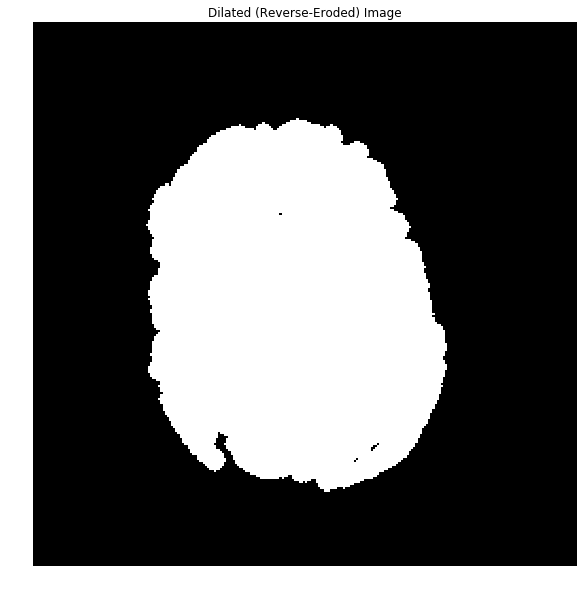

In [88]:
grown = np.invert( brain_mask )
selem = skimage.morphology.disk(4)
grown = skimage.morphology.erosion( grown,selem )
grown = np.invert( grown )
ShowImage( 'Dilated (Reverse-Eroded) Image',grown,'gray' )

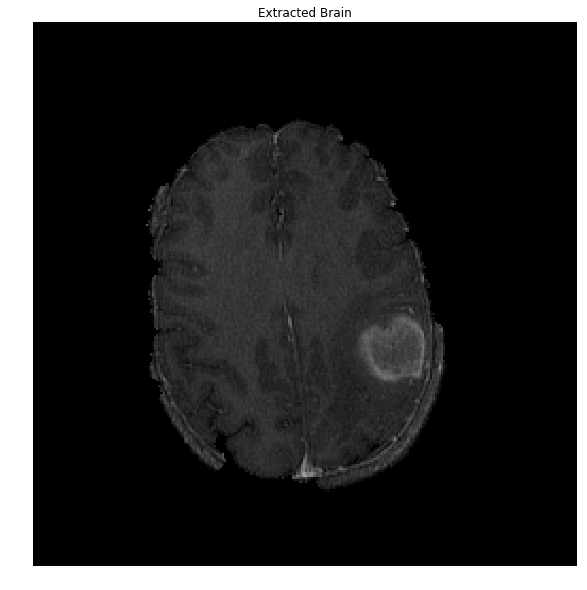

In [89]:
# Get the area taken by each component.  (Ignore label 0 since this is the background.)
marker_area = [ np.sum( markers==m ) for m in range( np.max( markers ) ) if m!=0 ] 

# Get label of largest component by area
largest_component = np.argmax( marker_area ) + 1  # add 1 since we dropped zero above                        

# Get pixels which correspond to the brain.
brain_mask = ( markers==largest_component )

# Make a copy of the original image and select only those pixels corresponding to the brain.
image_brain_out = np.dstack( ( image_brain, )*3 )
image_brain_out[ grown==False ] = ( 0,0,0 )
ShowImage( 'Extracted Brain',image_brain_out,'rgb' )

The dura mater (hard encasing of the brain inside the skull) is still partiall visible, but the image is much cleaner without the skull.  You can repeat this process with a new threshold to pick out the tumor or to remove the dura mater completely.

At this point, we can build a pipeline to handle _all_ of the images in the data set at the same time.  We have two options:  we can load all of the images at once and process them, or load them one at a time and process them one at a time.  The former requires more memory, so it may not be preferred for extremely large data sets, but we'll use it here since there are some tools to handle that process.

In [67]:
brain_files_path = './data/0000*.png'
brain_images = skimage.io.imread_collection( brain_files_path )

If we rebuild our immediately preceding pipeline as a function, we can loop over and output the stripped images.

Compose a function `strip_skull` which accepts an image (as a NumPy array) as argument and returns the stripped image as a NumPy array.  (It shouldn't worry about the `drawn` portion since that can't be easily generalized.  Just erode more aggressively.)  Verify that it works for one of the images besides the one we just tested.  Then apply it to the whole pipeline.

In [90]:
def strip_skull( image ):
    threshold = skimage.filters.threshold_li( image )
    thresh = image > threshold
    selem = skimage.morphology.disk(3)
    eroded = skimage.morphology.erosion( thresh,selem )
    markers = skimage.morphology.label( eroded,connectivity=1 )
    # Get the area taken by each component.  (Ignore label 0 since this is the background.)
    marker_area = [ np.sum( markers==m ) for m in range( np.max( markers ) ) if m!=0 ] 

    # Get label of largest component by area
    largest_component = np.argmax( marker_area ) + 1  # add 1 since we dropped zero above                        

    # Get pixels which correspond to the brain.
    brain_mask = ( markers==largest_component )

    # Make a copy of the original image and select only those pixels corresponding to the brain.
    grown = np.invert( brain_mask )
    selem = skimage.morphology.disk(4)
    grown = skimage.morphology.erosion( grown,selem )
    grown = np.invert( grown )
    # Get the area taken by each component.  (Ignore label 0 since this is the background.)
    marker_area = [ np.sum( markers==m ) for m in range( np.max( markers ) ) if m!=0 ] 

    # Get label of largest component by area
    largest_component = np.argmax( marker_area ) + 1  # add 1 since we dropped zero above                        

    # Get pixels which correspond to the brain.
    brain_mask = ( markers==largest_component )

    # Make a copy of the original image and select only those pixels corresponding to the brain.
    image_brain_out = np.dstack( ( image_brain, )*3 )
    image_brain_out[ grown==False ] = ( 0,0,0 )
    return image_brain_out

In [93]:
brain_path = './data/000079.png'
image_brain = skimage.io.imread( brain_path )
image_brain = image_brain >> 8

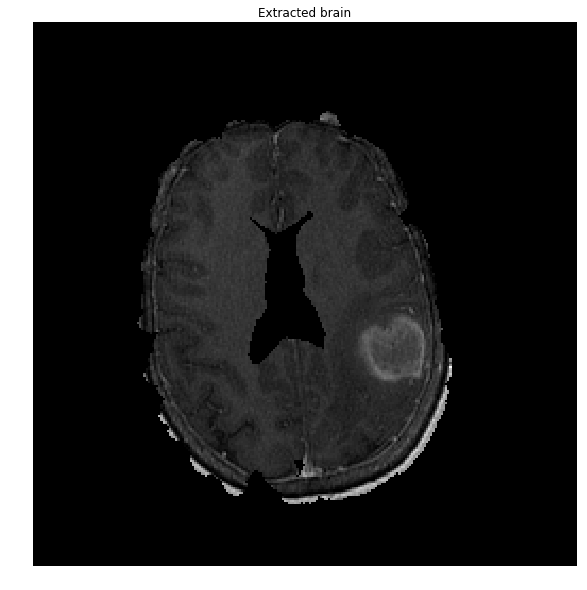

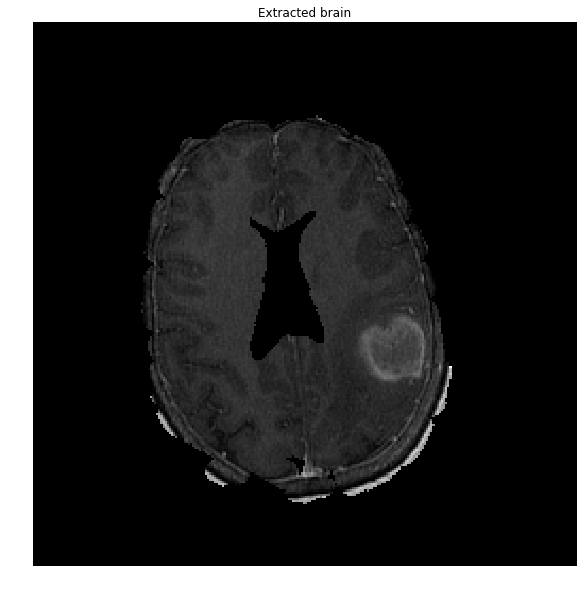

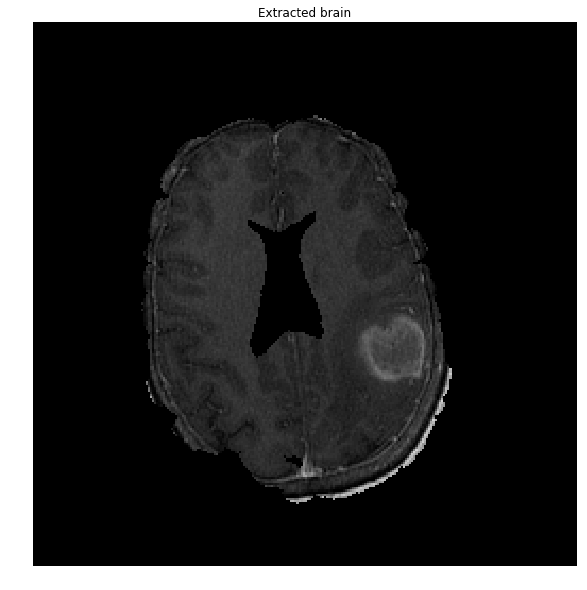

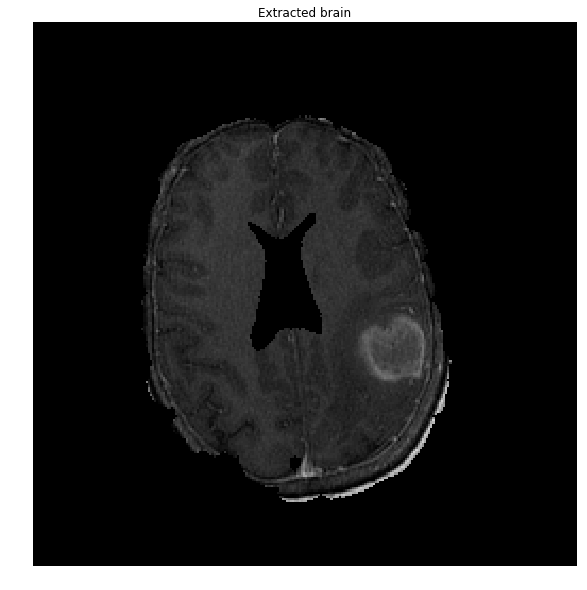

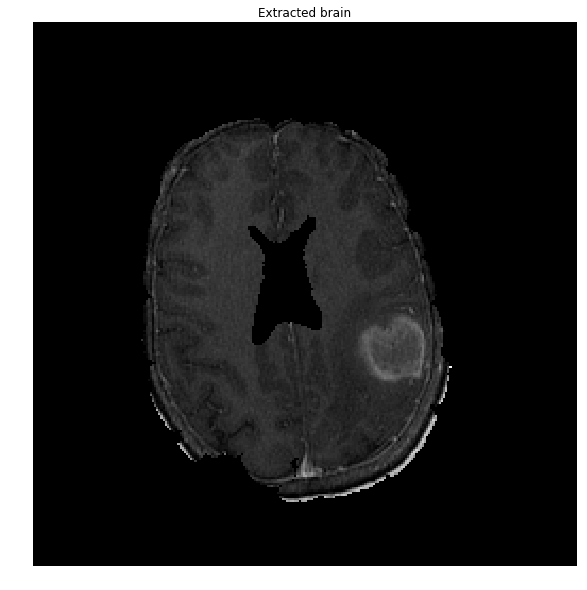

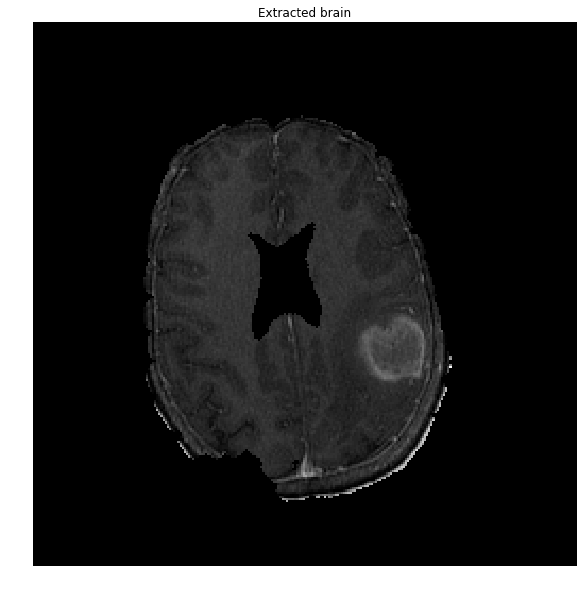

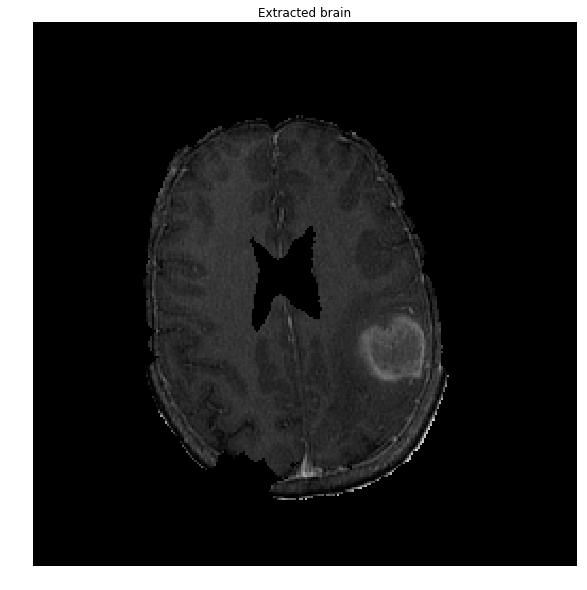

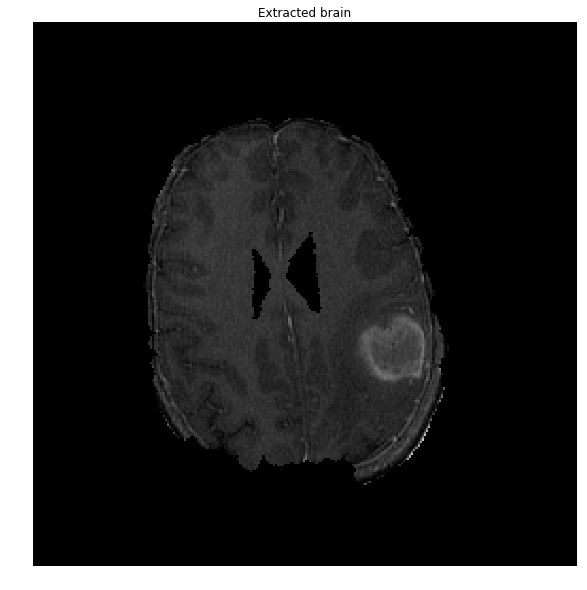

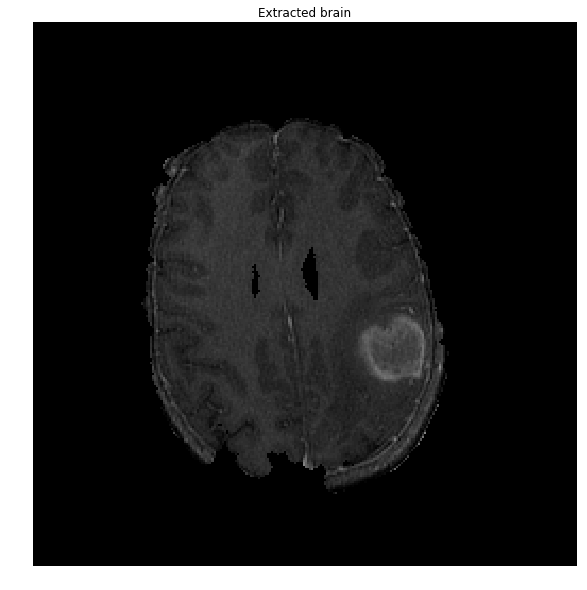

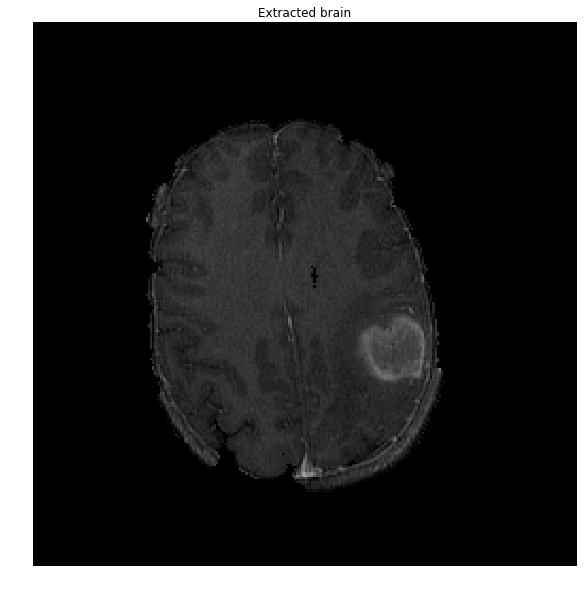

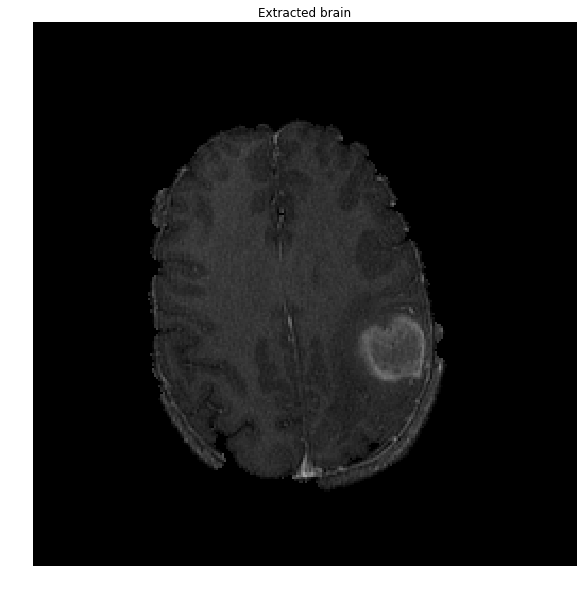

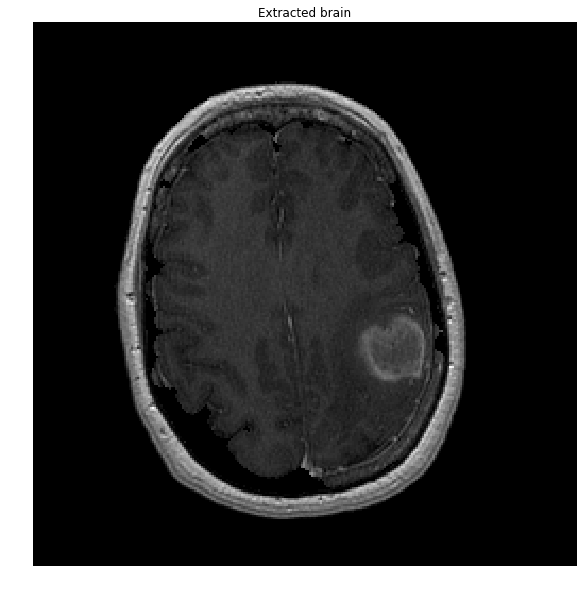

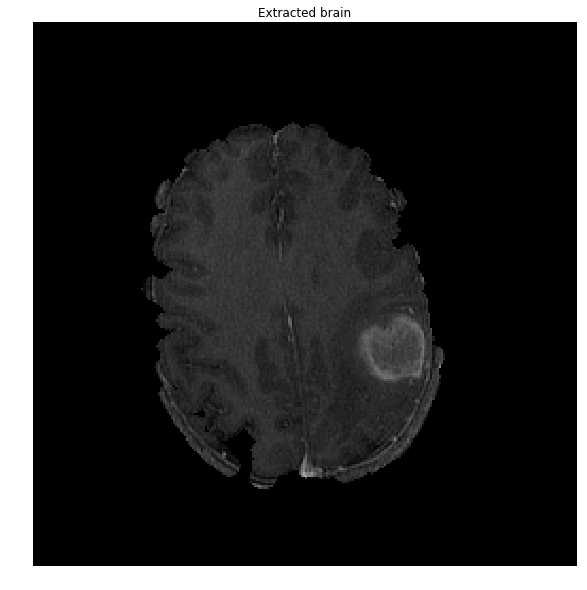

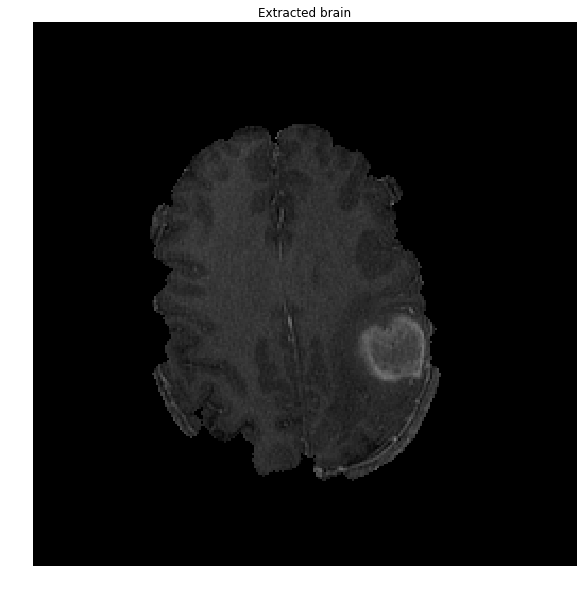

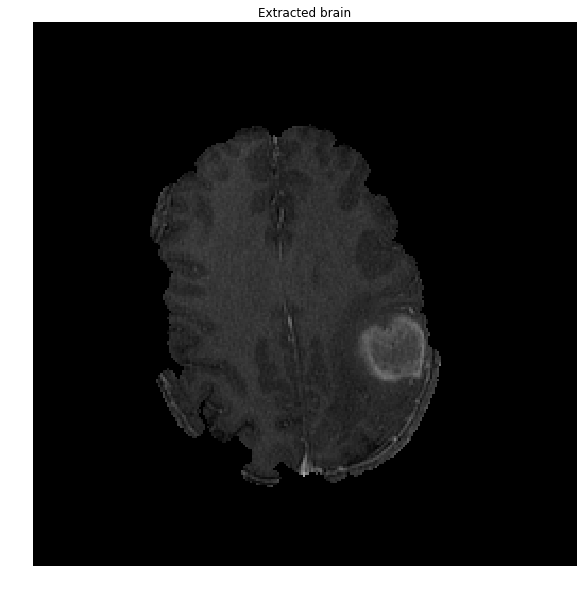

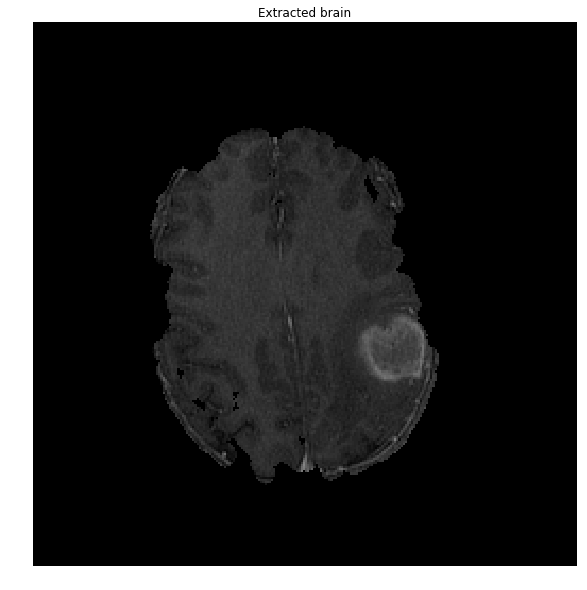

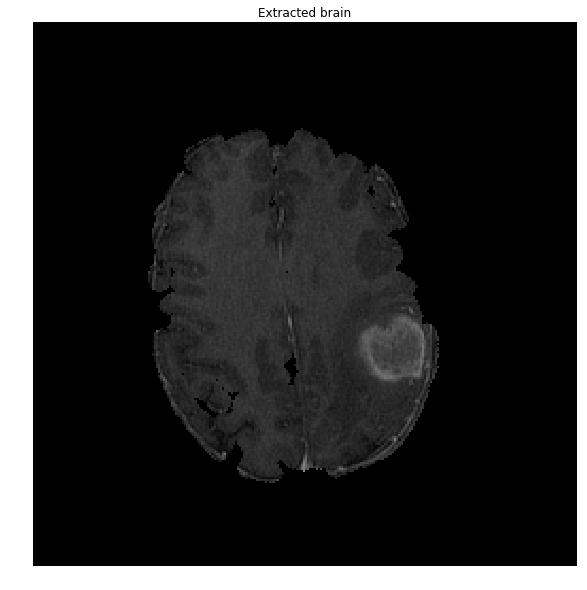

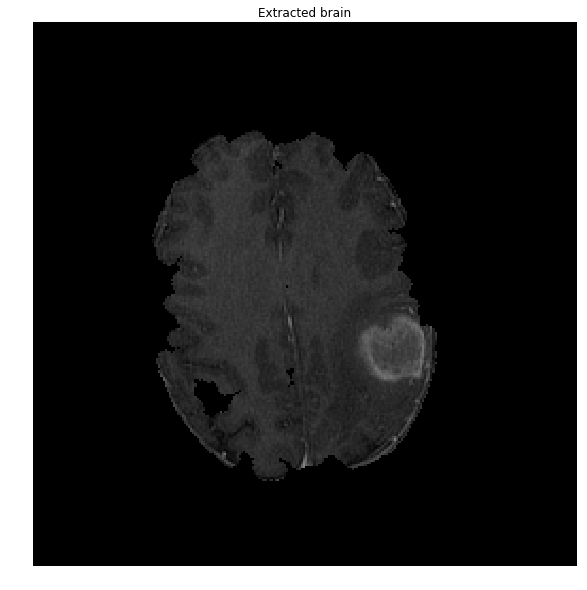

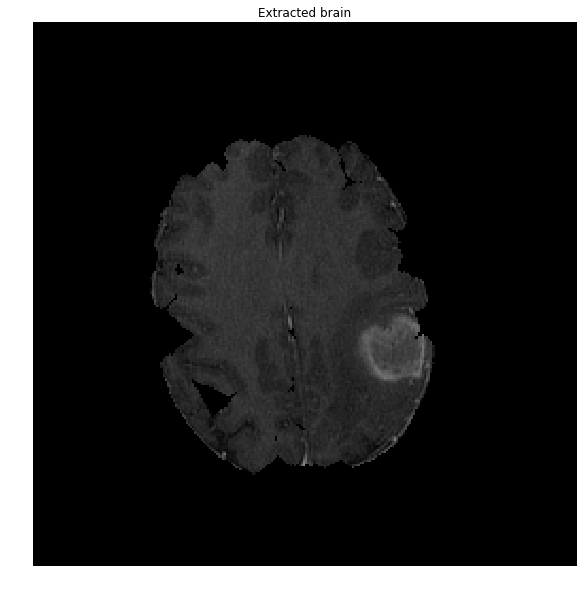

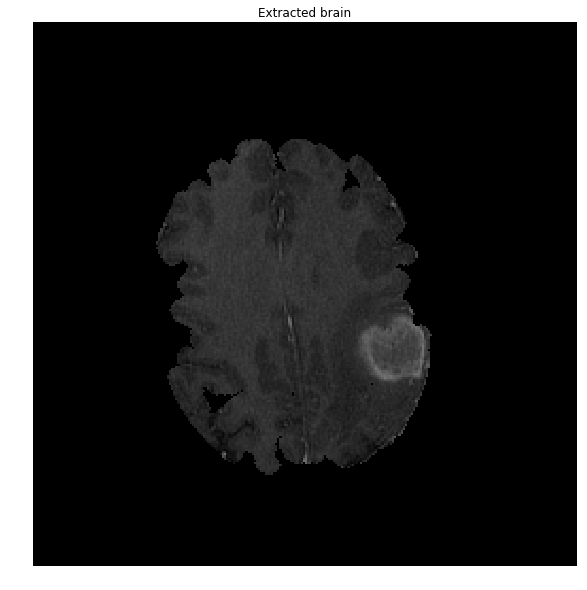

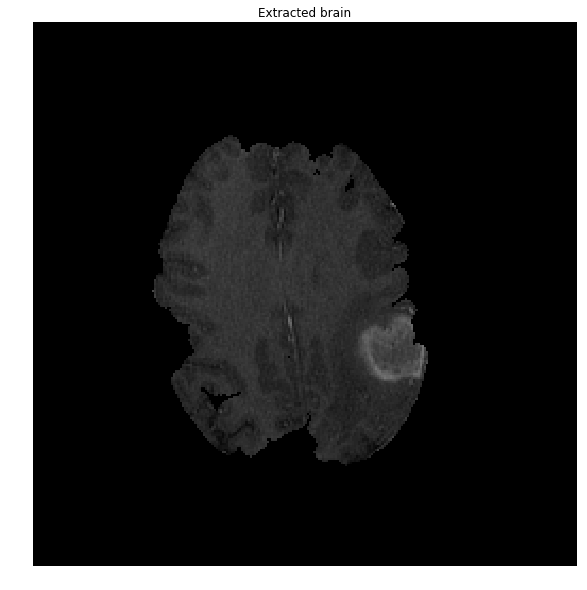

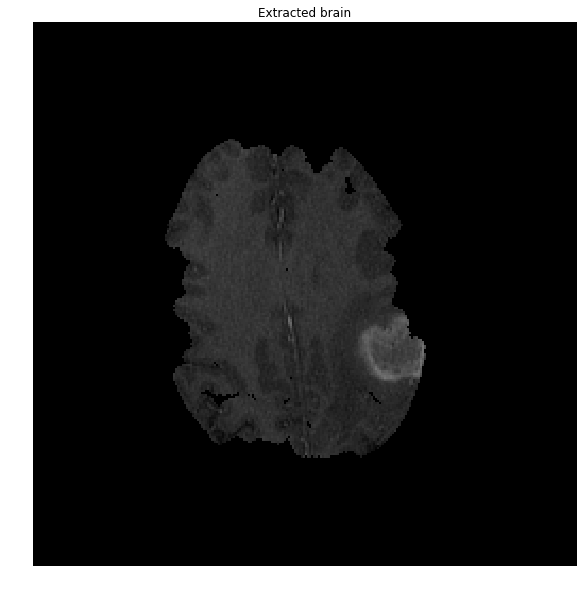

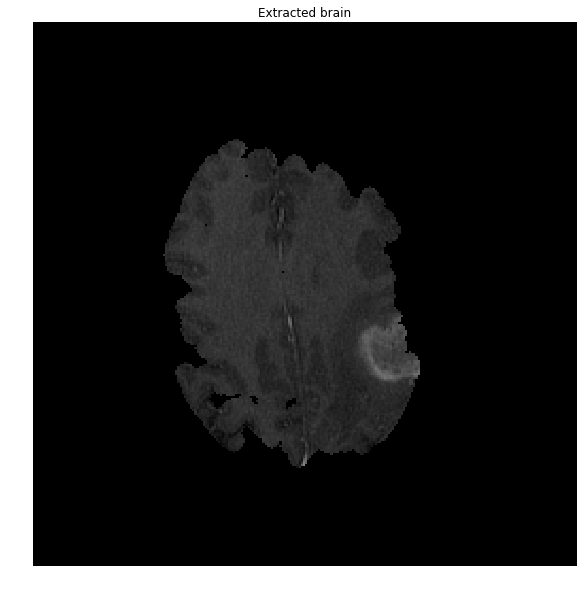

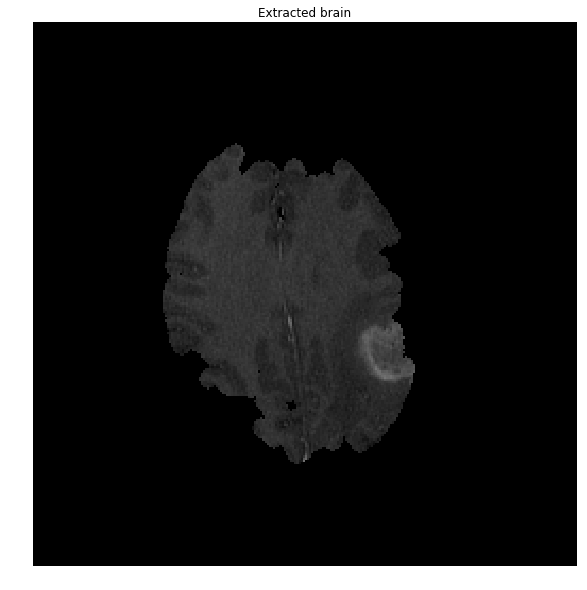

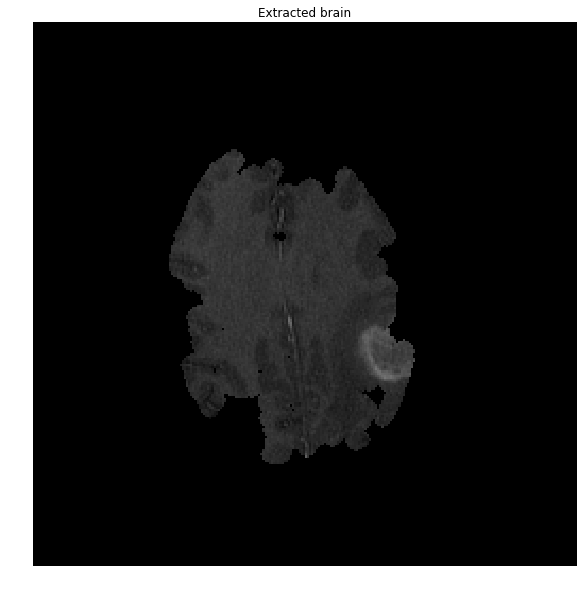

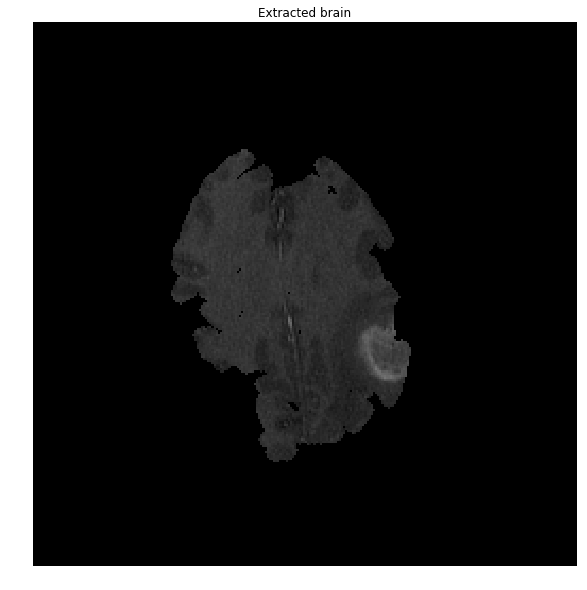

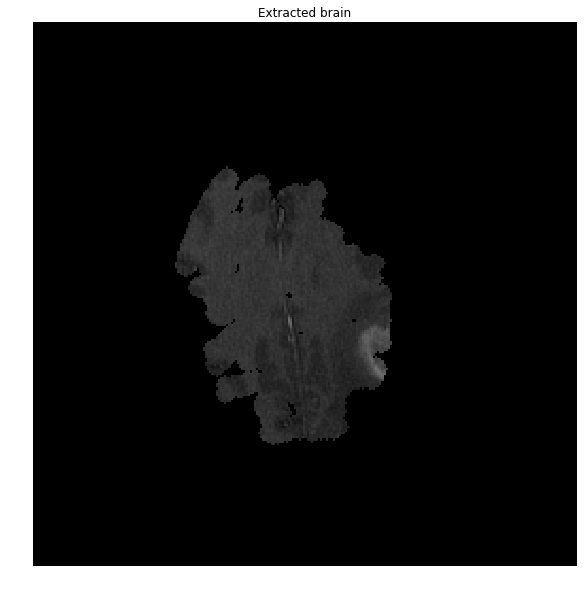

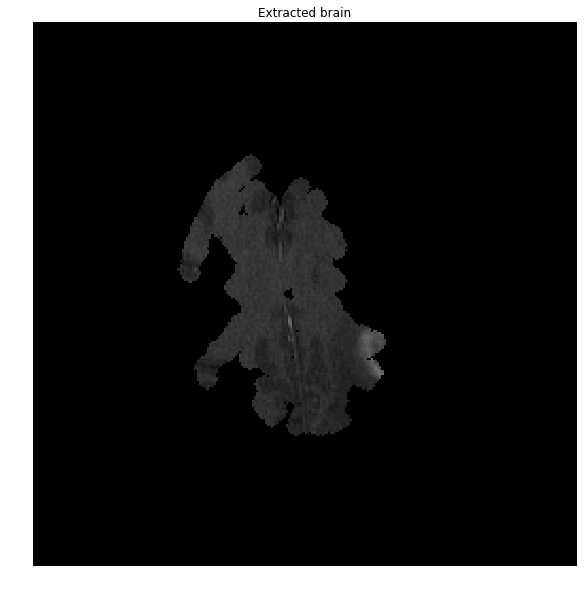

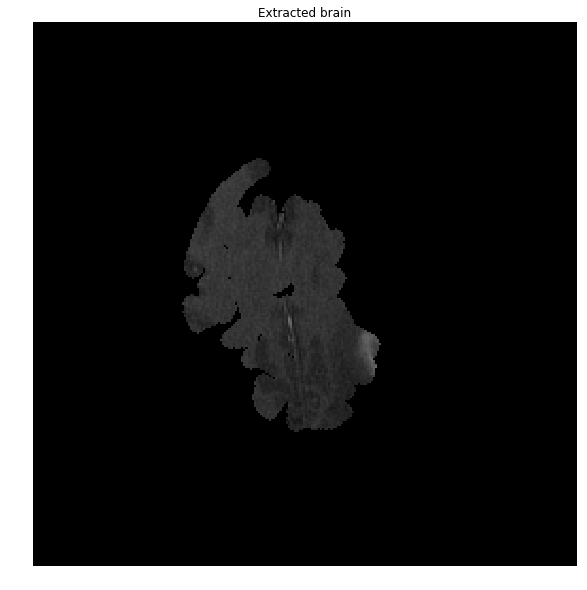

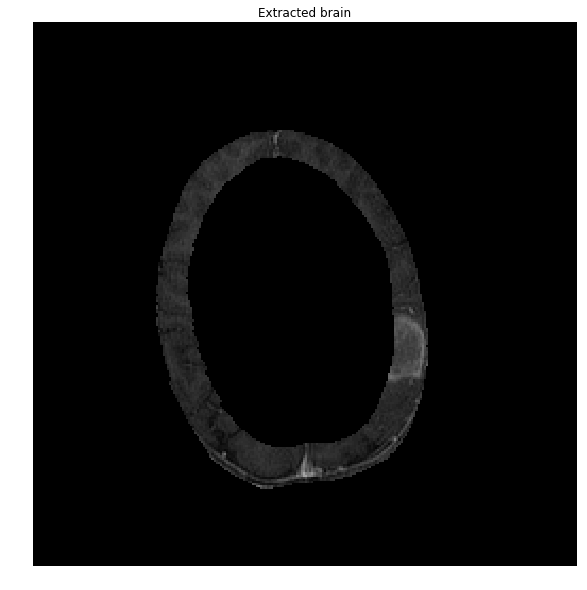

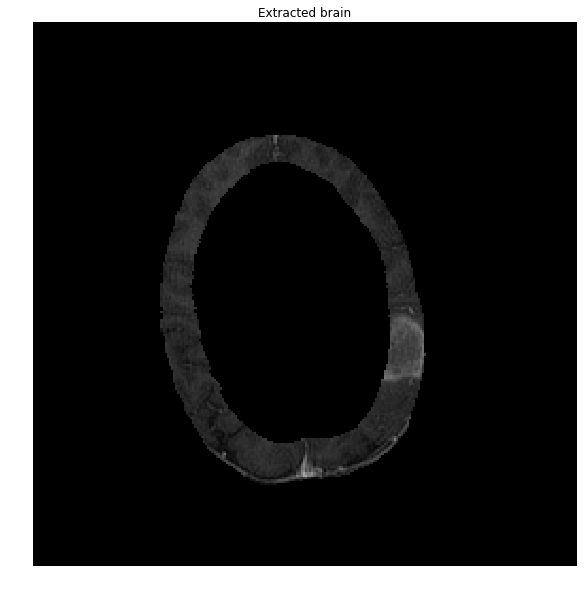

In [94]:
for ( brain_image,brain_image_path ) in zip( brain_images,brain_images.files ):
    brain_stripped = strip_skull( brain_image )
    ShowImage( 'Extracted brain',brain_stripped,'rgb')
    stripped_image_path = brain_image_path.replace( '.png','-stripped.png' )
    skimage.io.imsave( stripped_image_path,brain_stripped )